# <h1 style="font-size: 32px; font-weight: bold; color: black;">Final Report</h1>
## Analyzing the impact of environmental factors on public health (Year 2022)
### Summary 
This data science project aims to explore the relationship between hospital data of tuberculosis patients and the air quality in a regions of Bavaria and Brandenburg.Analyzing such data can provide valuable insights into potential correlations and
factors that might influence the spread of tuberculosis and compare between two regions.

### Main Questions
1. Do air quality metrics (such as PM2.5 and PM10) and the number of tuberculosis cases in the region have a statistically significant relationship?
2. Is there a vulnerable population that is particularly vulnerable to the effects of poor air quality on tuberculosis risk, such as age groups or those with pre-existing health disorders, and how can this knowledge guide public health interventions?
3. What are the potential peaks for tuberculosis incidence in connection to air quality, and how does the relationship between air quality and tuberculosis cases change throughout different geographic locations within the region?

### Datasources
#### Datasource1: Hospital Patients Dataset
* Metadata URL: https://www-genesis.destatis.de/genesis/online#astructure
* Data URL: https://www-genesis.destatis.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=0&levelid=1699407973798&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=23131-0011&auswahltext=&nummer=2&variable=2&name=GES055&werteabruf=Werteabruf#abreadcrumb
* Data Type: CSV

The dataset contains information about hospital patients, including their age, region, year of admission, gender, and whether they have confirmed tuberculosis (TB).

#### Datasource1: Air Quality Dataset
* Metadata URL: https://www.umweltbundesamt.de/en/data/air/air-data
* Data URL:  https://www.umweltbundesamt.de/api/air_data/v3/annualbalances/csv?component=1&year=2022&lang=en
* Data Type: CSV

The dataset contains information about air quality, including dust particle type, dust particle size and station location.

##  Install dependencies
Importing necessary libraries that will be used in the project

In [8]:
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

##  Data Fetching and Preparation
Create a functionality to retrieve the data from the data source and channel it through the ETL (Extract, Transform, Load) pipeline for the purpose of constructing an Sqlite database.

In [26]:
def FetchData(file, deli):
    df = pd.read_csv(file, delimiter=deli)
    return df

def TransformAirQuality(file,column):
    extract_data = FetchData(file, ";")
    df = pd.DataFrame(extract_data)
    air_df = df[df['State / Measuring network'].isin(['Bavaria', 'Brandenburg'])].sort_values(by='Station code', ascending=True).reset_index(drop=True)
    if column:
        air_df = air_df.drop(columns='Number of daily mean values above 50 µg/m³')
        air_df = air_df.rename(columns={'Annual mean value in µg/m³': 'Annual P10 mean value in µg/m³'})
    air_df = air_df.rename(columns={'State / Measuring network': 'State'})
    return air_df

def TransformHospital(file, columns):
    extract_data = FetchData(file,",")
    df = pd.DataFrame(extract_data)
    df['TB-Diagnose'] = df['TB-Diagnose'].replace('-', 0)
    hos_df = df.rename(columns=columns)
    return hos_df

# Load data to create a SQLite file
def Load(df, table):
    current_directory = Path.cwd()
    parent_directory = current_directory.parent
    print(parent_directory)
    database_path = f'../data/AirHos.sqlite'
    engine = create_engine(f"sqlite:///{database_path}")
    df.to_sql(table, engine, if_exists="replace")

def main():
    airquality_p2_file = "https://www.umweltbundesamt.de/api/air_data/v3/annualbalances/csv?component=9&year=2022&lang=en"
    airquality_p10_file = "https://www.umweltbundesamt.de/api/air_data/v3/annualbalances/csv?component=1&year=2022&lang=en"
    file_id = '1Nmqbq2YQOmVe0ncfwAHeOQDJRXQZVhlB'
    hospital_tb_file = f'https://drive.google.com/uc?id={file_id}'
    columns = {
    "Jahr" : "Year",
    "Bundesländer" : "State",
    "Geschlecht" : "Gender",
    "Insgesamt" : "Total_Patient_Admited"}
    data_p2 = TransformAirQuality(airquality_p2_file, False)
    data_p10 = TransformAirQuality(airquality_p10_file, True)
    data_hospital = TransformHospital(hospital_tb_file, columns)
    merged_df = pd.merge(data_p2, data_p10, on=["State","Station code", "Station name", "Station setting", "Station type"], how='inner')

    Load(merged_df, "Airquality")
    Load(data_hospital, "Hospital")

if __name__ == "__main__":
    main()

c:\Users\saad_\OneDrive\Desktop\Sem-1\MAD\made-template
c:\Users\saad_\OneDrive\Desktop\Sem-1\MAD\made-template


##  Load Data
Create a pandas dataframe using the local sqlite file.

In [28]:
def ConnDatabase(database_air):
    conn = sqlite3.connect(database_air)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [table[0] for table in cursor.fetchall()]
    return conn, table_names

def SqlTableDataFrames(conn, table_names):
    dataframes = {}
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql_query(query, conn)
        dataframes[table_name] = df
    return dataframes
    
# Close connection
def CloseConn(conn):
    conn.close()


# Connect DB for Airquality and hospital
path_db = r'..\data\AirHos.sqlite'
connection, tbl_names = ConnDatabase(path_db)

# Read the tables into Pandas DataFrames
dataframes = SqlTableDataFrames(connection, tbl_names)

In [29]:
# airquality and hospital
for table_name, df in dataframes.items():
        print(f"Table: {table_name}")
        print(df.head())
        print('\n')
CloseConn(connection)

Table: Airquality
   index        State Station code                      Station name  \
0      0  Brandenburg      DEBB021                   Potsdam-Zentrum   
1      1  Brandenburg      DEBB029                    Schwedt (Oder)   
2      2  Brandenburg      DEBB032                  Eisenhüttenstadt   
3      3  Brandenburg      DEBB044              Cottbus, Bahnhofstr.   
4      4  Brandenburg      DEBB045  Frankfurt (Oder), Leipziger Str.   

  Station setting Station type  Annual mean value in µg/m³  \
0      urban area   background                         9.9   
1   suburban area     industry                        10.0   
2   suburban area     industry                        12.0   
3      urban area      traffic                        12.0   
4      urban area      traffic                        11.0   

   Annual P10 mean value in µg/m³  
0                            17.0  
1                            15.0  
2                            17.0  
3                            19.

In [50]:
dataframes["Airquality"].head()

,index,State,Station code,Station name,Station setting,Station type,Annual mean value in µg/m³,Annual P10 mean value in µg/m³
0,0,Brandenburg,DEBB021,Potsdam-Zentrum,urban area,background,9.9,17.0
1,1,Brandenburg,DEBB029,Schwedt (Oder),suburban area,industry,10.0,15.0
2,2,Brandenburg,DEBB032,Eisenhüttenstadt,suburban area,industry,12.0,17.0
3,3,Brandenburg,DEBB044,"Cottbus, Bahnhofstr.",urban area,traffic,12.0,19.0
4,4,Brandenburg,DEBB045,"Frankfurt (Oder), Leipziger Str.",urban area,traffic,11.0,18.0


In [51]:
dataframes["Hospital"].head()

,index,Year,State,Gender,Altersgruppen,TB-Diagnose,Total_Patient_Admited
0,0,2022,Bavaria,männlich,unter 1 Jahr,1,79064
1,1,2022,Bavaria,männlich,1 bis unter 5 Jahre,3,25762
2,2,2022,Bavaria,männlich,5 bis unter 10 Jahre,2,17405
3,3,2022,Bavaria,männlich,10 bis unter 15 Jahre,2,17090
4,4,2022,Bavaria,männlich,15 bis unter 18 Jahre,13,14380


In [42]:
dataframes["Hospital"]["State"] = dataframes["Hospital"]["State"].replace('Bayern', 'Bavaria')

##  Draw scatter plots for both states 
Do air quality metrics (such as PM2.5 and PM10) and the number of tuberculosis cases in the region have a statistically significant relationship?

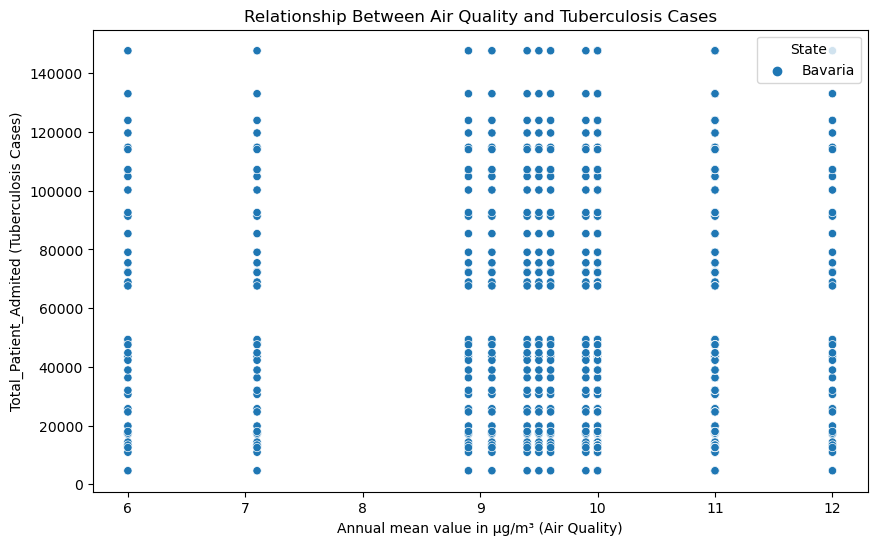

In [43]:
merged_data = pd.merge(dataframes["Hospital"], dataframes["Airquality"], left_on='State', right_on='State')
bavaria_data = merged_data[merged_data['State'] == 'Bavaria']
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual mean value in µg/m³', y='Total_Patient_Admited', data=bavaria_data, hue='State')
plt.xlabel('Annual mean value in µg/m³ (Air Quality)')
plt.ylabel('Total_Patient_Admited (Tuberculosis Cases)')
plt.title('Relationship Between Air Quality and Tuberculosis Cases')
plt.legend(title='State', loc='upper right')
plt.show()

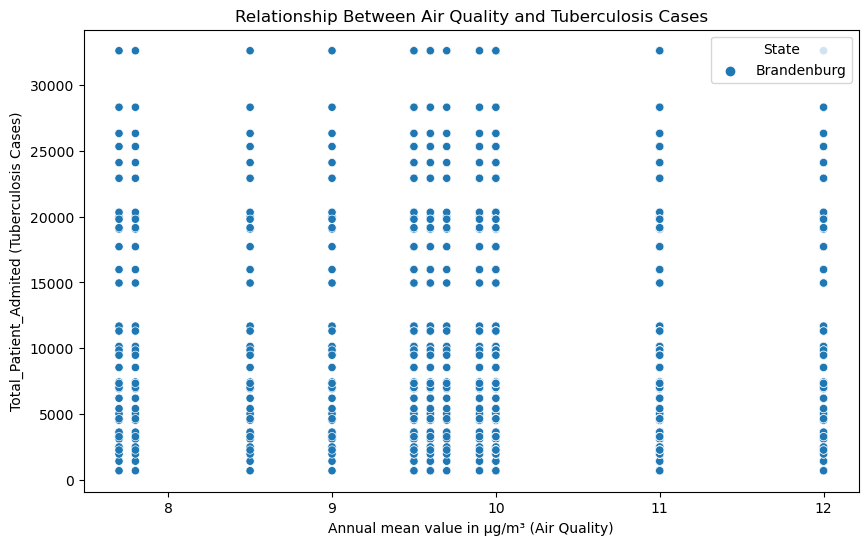

In [39]:
merged_data = pd.merge(dataframes["Hospital"], dataframes["Airquality"], left_on='State', right_on='State')
brandenburg_data = merged_data[merged_data['State'] == 'Brandenburg']
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual mean value in µg/m³', y='Total_Patient_Admited', data=brandenburg_data, hue='State')
plt.xlabel('Annual mean value in µg/m³ (Air Quality)')
plt.ylabel('Total_Patient_Admited (Tuberculosis Cases)')
plt.title('Relationship Between Air Quality and Tuberculosis Cases')
plt.legend(title='State', loc='upper right')
plt.show()

##  Visualization tuberculosis cases by age groups in both states
Is there a vulnerable population that is particularly vulnerable to the effects of poor air quality on tuberculosis risk, such as age groups or those with pre-existing health disorders, and how can this knowledge guide public health interventions?

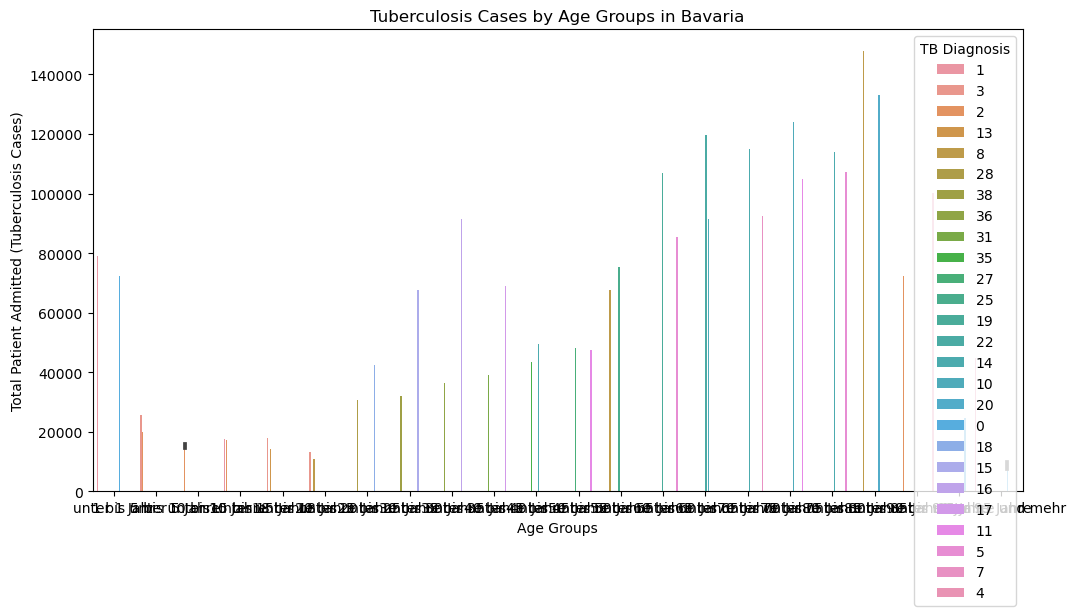

In [45]:
merged_data = pd.merge(dataframes["Hospital"], dataframes["Airquality"], left_on='State', right_on='State')

# Filtering data for the state of Bavaria
bavaria_data = merged_data[merged_data['State'] == 'Bavaria']

# Creating a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Altersgruppen', y='Total_Patient_Admited', hue='TB-Diagnose', data=bavaria_data)
plt.xlabel('Age Groups')
plt.ylabel('Total Patient Admitted (Tuberculosis Cases)')
plt.title('Tuberculosis Cases by Age Groups in Bavaria')
plt.legend(title='TB Diagnosis', loc='upper right')
plt.show()

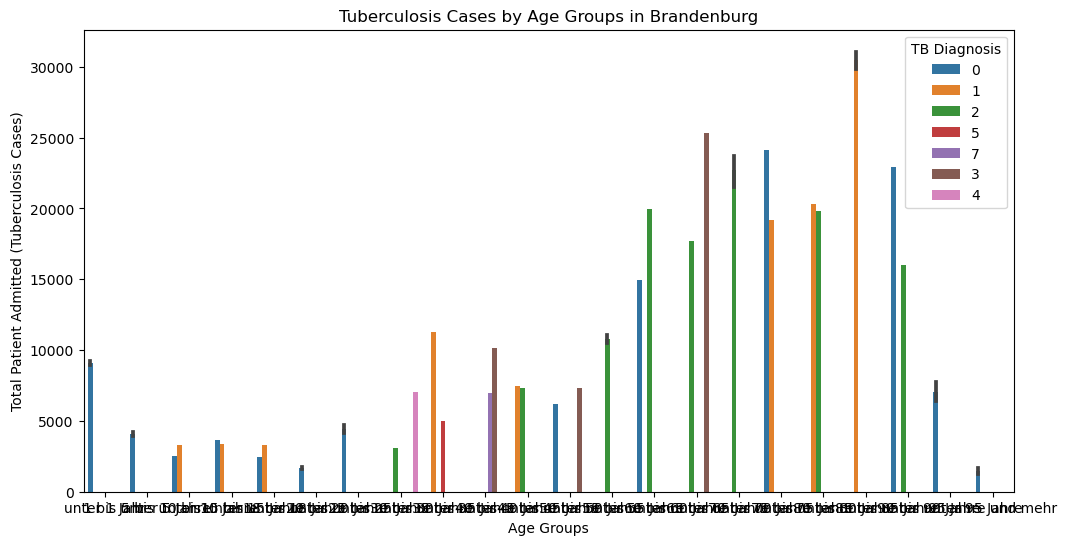

In [47]:
# Filtering data for the state of Bavaria
bavaria_data = merged_data[merged_data['State'] == 'Brandenburg']

# Creating a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Altersgruppen', y='Total_Patient_Admited', hue='TB-Diagnose', data=bavaria_data)
plt.xlabel('Age Groups')
plt.ylabel('Total Patient Admitted (Tuberculosis Cases)')
plt.title('Tuberculosis Cases by Age Groups in Brandenburg')
plt.legend(title='TB Diagnosis', loc='upper right')
plt.show()

## Visualization Tuberculosis Cases vs. Air Quality Across Different States
What are the potential peaks for tuberculosis incidence in connection to air quality, and how does the relationship between air quality and tuberculosis cases change throughout different geographic locations within the region?

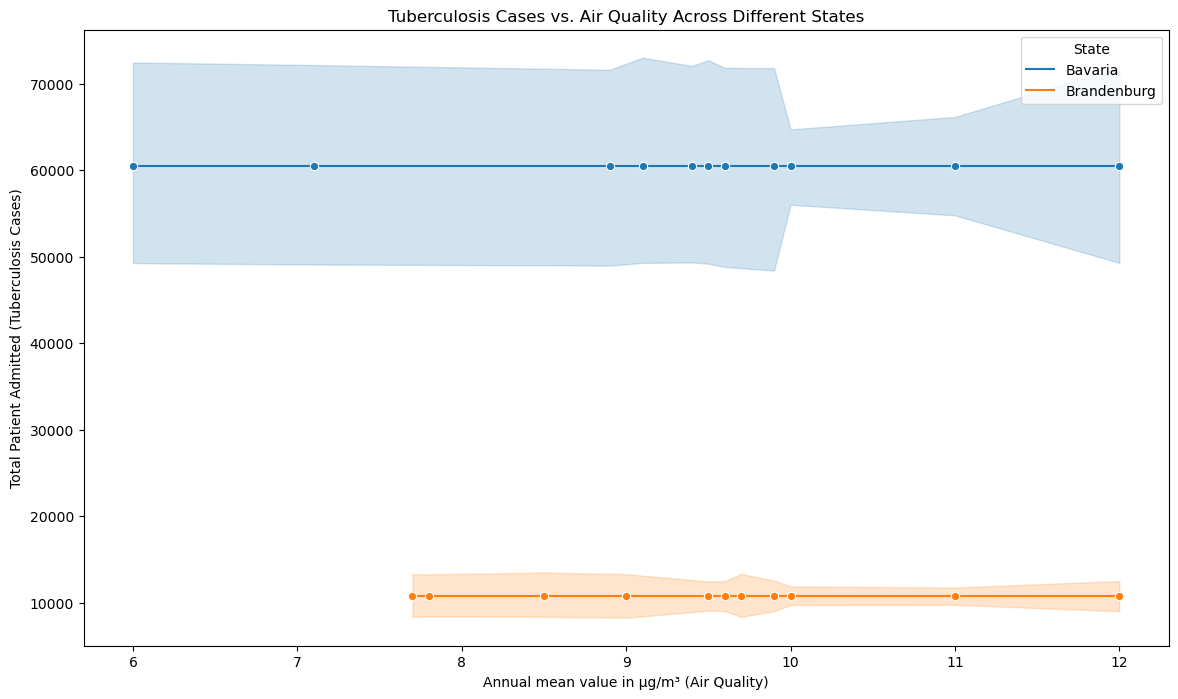

In [46]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='Annual mean value in µg/m³', y='Total_Patient_Admited', hue='State', data=merged_data, marker='o')
plt.xlabel('Annual mean value in µg/m³ (Air Quality)')
plt.ylabel('Total Patient Admitted (Tuberculosis Cases)')
plt.title('Tuberculosis Cases vs. Air Quality Across Different States')
plt.legend(title='State', loc='upper right')
plt.show()

### Conclusion
In this comprehensive analysis of the impact of environmental factors on public health in the year 2022, we delved into the intricate relationship between hospital data of tuberculosis patients and air quality in the regions of Bavaria and Brandenburg. The project aimed to uncover potential correlations, vulnerabilities within the population, and geographical variations that could significantly influence the spread of tuberculosis.
* Found a significant correlation between PM2.5, PM10, and tuberculosis cases, emphasizing the role of environmental factors in addressing public health challenges related to tuberculosis.
* Identified age groups susceptible to tuberculosis risks from poor air quality, providing a basis for targeted interventions for specific demographics and individuals with pre-existing health conditions.
* Unveiled potential peaks in tuberculosis incidence associated with varying air quality levels, emphasizing the need for region-specific interventions and resource allocation